In [86]:
!pip install rawpy matplotlib
!pip install opencv-python


In [87]:
import rawpy

out_of_focus = r"C:\code\astrocam\outoffocus\Image741.nef"
in_focus = r"C:\code\astrocam\light\Image752.nef"
with open(in_focus, "rb") as f:
  rawimg = rawpy.imread(f)
  img = rawimg.postprocess()



In [88]:
img.shape

(2868, 4310, 3)

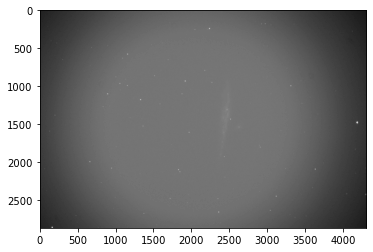

In [89]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [90]:
Bs = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(7,7))
Bmi = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(21,21))
Be = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(25,25))
Bmo = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(29,29))
d = (Bmo.shape[0] - Bmi.shape[0]) // 2
Bm = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(29,29))
Bm[d:d+Bmi.shape[0], d:d+Bmi.shape[0]] -= Bmi


In [91]:
K = cv2.morphologyEx(gray, cv2.MORPH_OPEN, Bs)
N = cv2.morphologyEx(cv2.morphologyEx(gray, cv2.MORPH_DILATE, Bm), cv2.MORPH_ERODE, Be)
print(K.shape, N.shape)

(2868, 4310) (2868, 4310)


In [92]:
R = K -np.minimum(K,N)

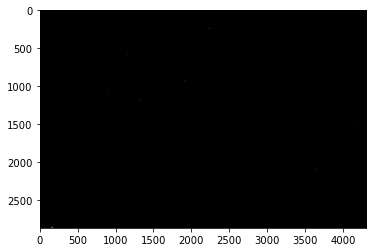

In [93]:
plt.imshow(R, cmap='gray')

In [94]:
numstars, labels, stats, centroids = cv2.connectedComponentsWithStats(R, 4, cv2.CV_16U, cv2.CCL_WU)

In [95]:
centroids

array([[2.15452989e+03, 1.43344762e+03],
       [5.60837209e+02, 1.90697674e+00],
       [2.96892045e+03, 1.80602273e+02],
       [2.92040000e+03, 1.82100000e+02],
       [2.23398544e+03, 2.41912621e+02],
       [6.79000000e+02, 4.95000000e+02],
       [1.15443709e+03, 5.79516556e+02],
       [2.17200000e+03, 7.93000000e+02],
       [1.51000000e+03, 8.64500000e+02],
       [1.91399435e+03, 9.33683616e+02],
       [2.26555556e+03, 9.51444444e+02],
       [1.05303448e+03, 9.65448276e+02],
       [1.15094366e+03, 9.92450704e+02],
       [3.30711429e+03, 9.96457143e+02],
       [8.91434783e+02, 1.10273913e+03],
       [1.87144928e+03, 1.10204348e+03],
       [1.32553846e+03, 1.17868047e+03],
       [1.97000000e+02, 1.38250000e+03],
       [2.51288043e+03, 1.43495652e+03],
       [4.18115758e+03, 1.47898182e+03],
       [1.35800000e+03, 1.52650000e+03],
       [1.28000000e+02, 1.59400000e+03],
       [1.96529032e+03, 1.60847312e+03],
       [6.56556452e+02, 1.99573387e+03],
       [9.425909

In [96]:
def getStar(staridx):
  centorid_x, centroid_y = centroids[staridx]
  width = stats[staridx, cv2.CC_STAT_WIDTH] / 2
  height = stats[staridx, cv2.CC_STAT_HEIGHT] / 2
  min_row = int(max(0, centroid_y - height))
  max_row = int(min(gray.shape[0], centroid_y + height+1))
  min_col = int(max(0, centorid_x - width))
  max_col = int(min(gray.shape[1], centorid_x + width+1))
  cell = gray[min_row:max_row, min_col:max_col]
  return cell

Calculating centroid with higher accuracy
- https://www.lost-infinity.com/night-sky-image-processing-part-4-calculate-the-star-centroid-with-sub-pixel-accuracy/

In [97]:
star = getStar(1)

Optionally remove background

In [98]:
bg = np.percentile(img,5)
star = np.clip(star - bg, 0, 255)

In [99]:
star

array([[15., 20., 22., 21., 20., 20., 31., 42., 47., 45., 39., 39., 36.,
        33., 25., 19., 18., 21., 17., 16.],
       [17., 20., 21., 25., 27., 28., 29., 41., 50., 43., 32., 34., 33.,
        29., 23., 18., 17., 18., 14., 16.],
       [21., 19., 20., 28., 33., 38., 38., 41., 44., 41., 35., 29., 27.,
        27., 23., 18., 16., 16., 15., 15.],
       [23., 20., 15., 23., 32., 38., 40., 40., 40., 37., 32., 27., 26.,
        26., 23., 18., 12., 13., 18., 18.],
       [22., 22., 24., 25., 32., 38., 33., 32., 34., 35., 28., 22., 23.,
        21., 19., 18., 13., 12., 15., 16.],
       [28., 24., 30., 32., 34., 36., 28., 22., 30., 35., 21., 16., 19.,
        16., 11., 16., 20., 14., 17., 18.],
       [29., 28., 30., 31., 34., 31., 26., 21., 21., 18., 20., 17., 16.,
        17., 16., 13., 20., 16., 16., 14.],
       [30., 32., 32., 31., 32., 31., 21., 13., 11., 16., 21., 22., 17.,
        18., 18., 14., 16., 14.,  7.,  7.],
       [32., 28., 28., 30., 25., 21., 20., 14., 12., 22., 21., 2

1. Calculate the IWC

In [100]:
cx = np.sum(np.full(star.shape, np.arange(star.shape[1])) * (star**2)) / (np.sum(star**2))
cy = np.sum(np.full(star.shape, np.arange(star.shape[0]).reshape(star.shape[0],1)) * (star**2)) / (np.sum(star**2))
print(cx, cy)
cx = round(cx)
cy = round(cy)
print(star)
print(cx, cy)

7.663519715142961 4.468843761304554
[[15. 20. 22. 21. 20. 20. 31. 42. 47. 45. 39. 39. 36. 33. 25. 19. 18. 21.
  17. 16.]
 [17. 20. 21. 25. 27. 28. 29. 41. 50. 43. 32. 34. 33. 29. 23. 18. 17. 18.
  14. 16.]
 [21. 19. 20. 28. 33. 38. 38. 41. 44. 41. 35. 29. 27. 27. 23. 18. 16. 16.
  15. 15.]
 [23. 20. 15. 23. 32. 38. 40. 40. 40. 37. 32. 27. 26. 26. 23. 18. 12. 13.
  18. 18.]
 [22. 22. 24. 25. 32. 38. 33. 32. 34. 35. 28. 22. 23. 21. 19. 18. 13. 12.
  15. 16.]
 [28. 24. 30. 32. 34. 36. 28. 22. 30. 35. 21. 16. 19. 16. 11. 16. 20. 14.
  17. 18.]
 [29. 28. 30. 31. 34. 31. 26. 21. 21. 18. 20. 17. 16. 17. 16. 13. 20. 16.
  16. 14.]
 [30. 32. 32. 31. 32. 31. 21. 13. 11. 16. 21. 22. 17. 18. 18. 14. 16. 14.
   7.  7.]
 [32. 28. 28. 30. 25. 21. 20. 14. 12. 22. 21. 21. 19. 17. 13. 14. 12. 15.
  11. 14.]
 [32. 30. 30. 29. 27. 17. 27.  9. 18. 22. 17.  9. 18. 13. 13. 18. 16. 12.
  18. 14.]
 [31. 30. 25. 21. 21. 16. 21.  7. 18. 21. 16. 11. 12. 13. 14. 14. 14. 14.
  18. 14.]
 [23. 24. 27. 24. 16. 19. 22.

Get 3x3 around IWC

In [101]:
star[cy-1:cy+2, cx-1:cx+2]

array([[40., 40., 37.],
       [32., 34., 35.],
       [22., 30., 35.]])

2. Round cx, cy to nearest integer and then iteratively improve.

In [102]:
import math

def calculate_centroid(star: np.ndarray):
    bg = np.percentile(star, 5)
    star = np.clip(star - bg, 0, 255)
    cx = np.sum(np.full(star.shape, np.arange(star.shape[1])) * (star**2)) / (np.sum(star**2))
    cy = np.sum(np.full(star.shape, np.arange(star.shape[0]).reshape(star.shape[0],1)) * (star**2)) / (np.sum(star**2))
    cx = round(cx)
    cy = round(cy)
    inImg = star[cy-1:cy+2, cx-1:cx+2]
    b1 = inImg[0, 0]; a2 = inImg[0, 1]; b2 = inImg[0, 2]
    a1 = inImg[1, 0];  c = inImg[1, 1]; a3 = inImg[1, 2]
    b4 = inImg[2, 0]; a4 = inImg[2, 1]; b3 = inImg[2, 2]

    for i in range(10):
        c2 = 2 * c
        sp1 = (a1 + a2 + c2) / 4
        sp2 = (a2 + a3 + c2) / 4
        sp3 = (a3 + a4 + c2) / 4
        sp4 = (a4 + a1 + c2) / 4
        
        #New maximum is center
        newC = max(sp1, sp2, sp3, sp4)
        
        # Calc position of new center
        ad = math.pow(2.0, -(i + 1.0))

        if (newC == sp1):
            cx = cx - ad # to the left
            cy = cy - ad # to the top

            # Calculate new sub pixel values
            b1n = (a1 + a2 + 2 * b1) / 4
            b2n = (c + b2 + 2 * a2) / 4
            b3n = sp3
            b4n = (b4 + c + 2 * a1) / 4
            a1n = (b1n + c + 2 * a1) / 4
            a2n = (b1n + c + 2 * a2) / 4
            a3n = sp2
            a4n = sp4

        elif (newC == sp2):
            cx = cx + ad # to the right
            cy = cy - ad # to the top

            # Calculate new sub pixel values
            b1n = (2 * a2 + b1 + c) / 4
            b2n = (2 * b2 + a3 + a2) / 4
            b3n = (2 * a3 + b3 + c) / 4
            b4n = sp4
            a1n = sp1
            a2n = (b2n + c + 2 * a2) / 4
            a3n = (b2n + c + 2 * a3) / 4
            a4n = sp3
        elif (newC == sp3):
            cx = cx + ad # to the right
            cy = cy + ad # to the bottom

            # Calculate new sub pixel values
            b1n = sp1
            b2n = (b2 + 2 * a3 + c) / 4
            b3n = (2 * b3 + a3 + a4) / 4
            b4n = (2 * a4 + b4 + c) / 4
            a1n = sp4
            a2n = sp2
            a3n = (b3n + 2 * a3 + c) / 4
            a4n = (b3n + 2 * a4 + c) / 4
        else:
            cx = cx - ad # to the left
            cy = cy + ad # to the bottom   

            # Calculate new sub pixel values
            b1n = (2 * a1 + b1 + c) / 4
            b2n = sp2
            b3n = (c + b3 + 2 * a4) / 4
            b4n = (2 * b4 + a1 + a4) / 4
            a1n = (b4n + 2 * a1 + c) / 4
            a2n = sp1
            a3n = sp3
            a4n = (b4n + 2 * a4 + c) / 4

            c = newC # Oi = Oi+1

            a1 = a1n
            a2 = a2n
            a3 = a3n
            a4 = a4n

            b1 = b1n
            b2 = b2n
            b3 = b3n
            b4 = b4n
    return cx, cy


In [103]:
cx, cy

(8, 4)

In [104]:
def plotStar3D(ax, star):
  xs = list(range(star.shape[1]))
  ys = list(range(star.shape[0]))
  xs, ys = np.meshgrid(xs, ys)
  X = np.arange(0, star.shape[1], 1)
  Y = np.arange(0, star.shape[0], 1)
  X, Y = np.meshgrid(X, Y)
  ax.plot_surface(xs, ys, star)

In [105]:
import scipy.optimize as opt

def twoD_GaussianScaledAmp(pos, xo, yo, sigma_x, sigma_y, amplitude, offset):
    """Function to fit, returns 2D gaussian function as 1D array"""
    x,y = pos
    xo = float(xo)
    yo = float(yo)    
    g = offset + amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

def getFWHM_GaussianFitScaledAmp(img, ax):
    """Get FWHM(x,y) of a blob by 2D gaussian fitting
    Parameter:
        img - image as numpy array
    Returns: 
        FWHMs in pixels, along x and y axes.
    """
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    x, y = np.meshgrid(x, y)
    #Parameters: xpos, ypos, sigmaX, sigmaY, amp, baseline
    initial_guess = (img.shape[1]/2,img.shape[0]/2,10,10,1,0)
    # subtract background and rescale image into [0,1], with floor clipping
    bg = np.percentile(img,5)
    img = np.clip((img - bg) / (img.max() - bg),0,1)

    popt, pcov = opt.curve_fit(twoD_GaussianScaledAmp, (x, y), 
                               img.ravel(), p0=None, #initial_guess,
                               bounds = (
                                   (0, 0, 1, 1, 0.5, -0.1), # Lower bound
                                   (img.shape[1], img.shape[0], img.shape[1], img.shape[0], 1.5, 0.5) # Upper bound
                                )
                            )
    xcenter, ycenter, sigmaX, sigmaY, amp, offset = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]

    z = offset + amp*np.exp( - (((x-xcenter)**2)/(2*sigmaX**2) + ((y-ycenter)**2)/(2*sigmaY**2)))
    ax.plot_surface(x,y,z)

    FWHM_x = np.abs(4*sigmaX*np.sqrt(-0.5*np.log(0.5)))
    FWHM_y = np.abs(4*sigmaY*np.sqrt(-0.5*np.log(0.5)))
    return (FWHM_x, FWHM_y, xcenter, ycenter)



In [116]:
from matplotlib.backends.backend_pdf import PdfPages
print(f"Num stars: {numstars}")
with PdfPages('fwhm_report.pdf') as pdf:
  for staridx in range(1, numstars):
    star = getStar(staridx)

    fig = plt.figure()
    ax = fig.add_subplot(2, 3, 1)
    ax.imshow(star, cmap='gray')

    ax = fig.add_subplot(2, 3, 2, projection='3d')
    plotStar3D(ax, star)

    ax = fig.add_subplot(2, 3, 3, projection='3d')
    cx, cy = calculate_centroid(star)
    FWHM_x, FWHM_y, xcenter, ycenter = getFWHM_GaussianFitScaledAmp(star, ax)

    ax = fig.add_subplot(2, 3, 4)
    ax.axis("off")
    ax.text(0, 0.75, f"FWHM: {FWHM_x:0.3f}, {FWHM_y:0.3f}")

    ax = fig.add_subplot(2, 3, 5)
    ax.axis("off")
    ax.text(0, 0.75, f"Centroid: ({cx:0.3f}, {cy:0.3f})")

    ax = fig.add_subplot(2, 3, 6)
    ax.axis("off")
    ax.text(0, 0.75, f", Curve center: ({xcenter:0.3f}, {ycenter:0.3f})")

    pdf.savefig()
    fig.show()
    plt.close()
    

Num stars: 38


C:\Users\anand\AppData\Local\Temp\ipykernel_12224\2388790508.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
